Esta prática foi baseada no Capítulo 4 do livro "Deep Learning with Python" (Chollet F., 2017). Nela iremos estudar arquiteturas de Redes Neurais Profundas para identificar gatos e cachorros em fotos. Esse dataset foi uma amostra extraida do [desafio do Kaggle](colab.research.google.com). O objetivo desta prática é:
- demonstrar como é possível usar Redes Neurais Convolucionarias (CNN)  mesmo em um dataset pequeno;
- conhecer o framework Keras;
- apresentar, por meio de mini-batches, como usar de forma eficiente a memória quando possuimos um dataset com milhares de atributos e, consequentemente, consumiria muita memória principal;
- demonstrar a vantagem da CNN ao comparar  com uma Rede Neural Totalmente Conectada (FC, do inglês _Fully Connected Network_) quando a entrada é uma imagem.





A limitação dessa prática é que assumimos que a imagem corresponde a apenas um animal (ou vários sendo apenas cachorros ou apenas gatos). Em um problema maior, deveriamos identificar objetos na imagem, para, logo após, realizarmos cortes na imagem e classificamos cada objeto identificado. 

Esta prática não possui testes unitários mas, para cada atividade, apresento que é esperado da mesma (ou como testar seu funcionamento). 

**Para entregar: ** Caso você tenha usado o google colab para algo, coloque o link. Elimine as imagens do dataset e os arquivos de modelos treinados (.h5). Não esqueça de executar todas os códigos para que eu consiga avaliar todas as saídas - não será considerado código que não foi executado e salvo a saída da execução no Jupyter. 

## Configuração da prática

Primeiramente, você deverá instalar o Keras e o TensorFlow:

pip3 install keras, tensorflow, pydot

Notei que em alguns computadores que não possuem GPU, deve-se instalar o `tensorflow-cpu` ao invés do tensorflow

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
from cats_vs_dogs import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Veja a inicialização da classe `Constantes` e da `ParametrosRedeNeural` no arquivo `cats_vs_dogs.py`. Você precisará desses valores ao longo da prática. Veja que lá, passamos o tipo de otimização usando classes do módulo [optimizers](https://keras.io/optimizers/) do Keras. Dentro desse objeto que definimos a taxa de aprendizado. No otimizador RMSProp, o parametro $\beta$ que usamos na nossa aula teórica é o parâmetro `rho` da inicialização da classe `RMSProp`.

## Notação utilizada

- $m$: quantidade de instâncias;
- $t$: tamanho do mini-batch;
- $w$: largura da imagem. Toda imagem possuirá o mesmo tamanho;
- $h$: altura da imagem;
- $c$: número de canais da imagem (ex. 1 canal: escala de cinzas; 3 canais: vermelho, verde e azul);
- $X$: Matriz de instâncias representadas pelos pixels das imagens. A ordem da matriz é $t \times h \times w \times c$;
- $\pmb{y}$: Vetor de tamanho $m$ representando a classe real de cada instância;
- $\pmb{\hat{y}}$: Vetor de predições que, para cada instancia, possui o valor predito para ela. Caso seja uma classificação binária, este valor será 0 ou 1.

## Obtenção do Dataset utilizando Batches e DataGenerator

Iremos usar um dataset de 4096 fotos de cachorros e gatos em que são 2048 fotos de cachorros e 2048 fotos de gato. Ele foi dividido de forma balanceada e aleatória em treino (2048 instancias), validação (1024 instâncias) e teste (1024 instâncias). Esse dataset está [disponivel no GitHub](https://github.com/daniel-hasan/cats-vs-dogs/archive/master.zip). Efetue o download, armazene no diretório `data` para fazer as tarefas. 

Ao trabalharmos milhares/milhões de imagens, nos deparamos com um problema: não conseguimos armazenar todas elas em memória principal. Por isso, a utilização do mini-batch gradient decent é importante, junto com os algoritmos de otimização que aprendemos (Gradiente Descent with Momentum, RMSProp e Adam). 

O Keras possui a classe [ImageGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) para preprocessar imagens,  trabalhar com mini-batches de imagens e fazer, inclusive, _Data Augmentation_.  Na primeira parte desta prática iremos utilizá-la apenas para facilitar o uso de mini-batches e realizar o preprocessamento. Mais especificamente, iremos usar o método [flow_from_data_dir](https://keras.io/preprocessing/image/#flow_from_directory) que recebe como entrada uma estrutura de diretórios similar a esta:

<img src="imgs/dataset-generator.png">

Nessa estrutura, cada subdiretório será uma classe com todas as imagens referentes a ela. `flow_from_data_dir` retorna um objeto iterável que, em cada iteração, retornará a tupla $(X,\pmb{y})$, ou seja, um mini-batch $X$ e o vetor de classe $\pmb{y}$ de cada instancia retornada pelo mini-batch (ver notação utilizada). Dessa forma, esse método armazena em memória principal apenas $t$ imagens por vez, ao invés do dataset completo.  

O `flow_from_data_dir` retorna um iterador que entraria em um loop infinito: após iterar sobre todas as imagens, ele faz a operação toda novamente. Por isso, caso desejarmos navegar em todas as imagens por um `for`, temos que definir um ponto de parada que, sem _data augmentation_, é o número de imagens. 

**Atividade 1 - Hello World DataGenerator:** crie uma pasta `img_toy_test` baseando-se estrutura acima com duas classes. Na primeira, coloque três cachorrinhos e, na outra, três gatinhos de sua escolha. Complete o código da função `plot_imgs_from_iterator` para efetuar a exibição dos mesmos. Essa função não possui teste unitário.  

Found 6 images belonging to 2 classes.
x treino shape: (2, 150, 150, 3)
y treino shape: (2,)


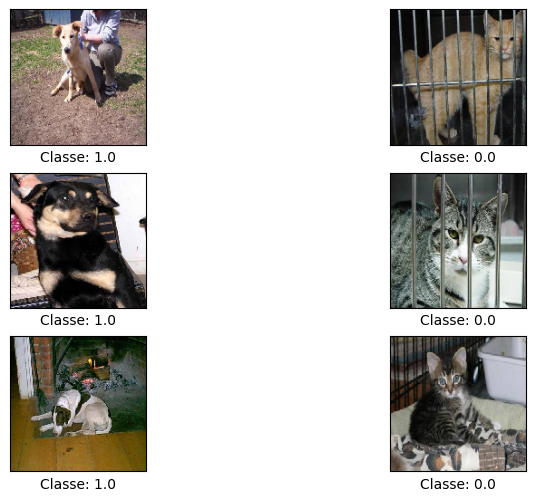

In [3]:
# No image generator, você usará apenas um parametro rescale 
# para deixar cada pixel entre 0 e 1. 
# Lembre-se que cada pixel originalmente é um valor entre 0 e 255

img_generator = ImageDataGenerator(rescale=1./255)

# ao fazer o iterador, você deverá definir: 
# O tamanho para que todas as imagens sejam redimensionadas; 
# O modo de classificação que será binário (caso contrario, a representação nao seria um vetor)
# O seed sempre fixo de Constantes.SEED para permitirmos a reprodutibilidade dos experimentos
# Escolha um tamanho do batch de 2
it_datagen = img_generator.flow_from_directory(
    "img_toy_test",
    target_size=(150, 150),
    batch_size=2,
    class_mode='binary',
    seed=Constantes.SEED
)

plot_imgs_from_iterator(it_datagen, num_lines=3, num_cols=2)


Veja que o iterador passou duas vezes pelas imagens apresentando, aleatoriamente, cada uma das imagens. Verifique as dimensões (shape) dos elementos para entender como as imagens foram representadas. Apenas na apresentação, o tamanho da imagem apresentada pelo gnuplot é redimensionada proporcional ao valor passado na função figsize. 

**Atividade 2 - função `get_dataset`: ** Nosso dataset já foi dividido em 3 partições: treino, teste e validação. Entendendo o funcionamento do `ImageDataGenerator`, você deverá implementar a função `get_dataset` que retornará um vetor três iteradores um para o treino, outro para teste e outro para validação. Esse vetor de iteradores obedecerá a mesma ordem de `Constantes.ARR_STR_DATA_DIR`. Para testar, você pode fazer um treino, teste e validação cada um com 6 itens e testar usando o `plot_imgs_from_iterator`.

Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.
Imagens de TREINO:
x treino shape: (6, 150, 150, 3)
y treino shape: (6,)


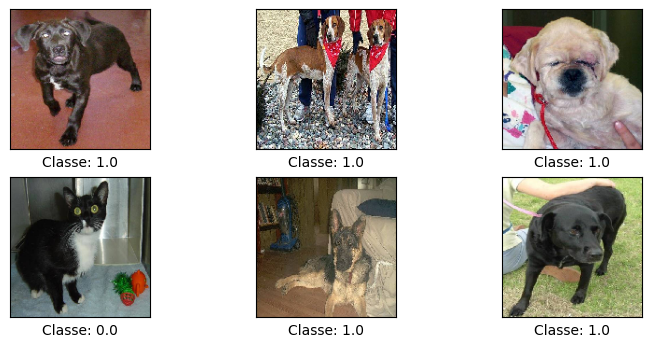

Imagens de VALIDAÇÃO:
x treino shape: (6, 150, 150, 3)
y treino shape: (6,)


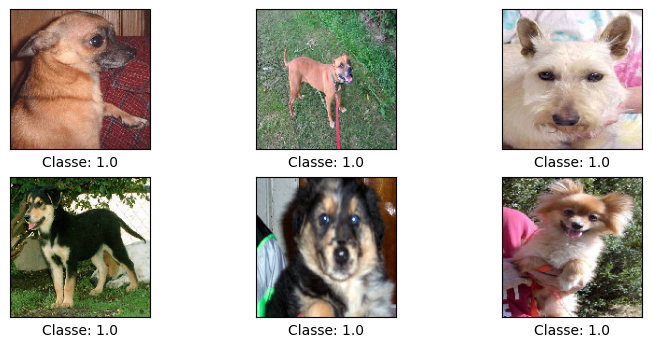

Imagens de TESTE:
x treino shape: (6, 150, 150, 3)
y treino shape: (6,)


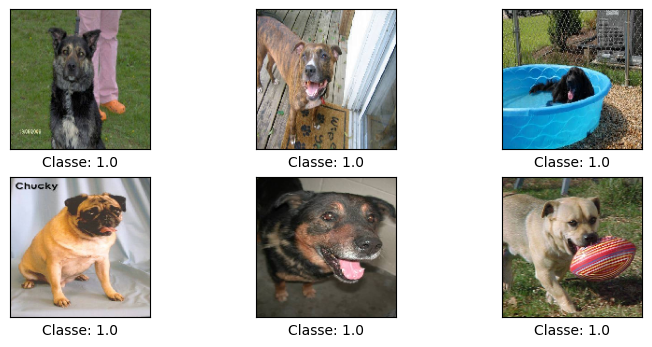

In [4]:
# Importações necessárias
from cats_vs_dogs import *

# Definir um batch_size pequeno para testar
param_training = ParametrosRedeNeural(int_batch_size=6)

# Gerar os iteradores
arr_iteradores = get_dataset(param_training, Constantes.ARR_STR_DATA_DIR)

# Separar os três iteradores
it_train = arr_iteradores[Constantes.IDX_TREINO]
it_validation = arr_iteradores[Constantes.IDX_VALIDACAO]
it_test = arr_iteradores[Constantes.IDX_TESTE]

# Testar exibindo imagens de treino
print("Imagens de TREINO:")
plot_imgs_from_iterator(it_train, num_lines=2, num_cols=3)

print("Imagens de VALIDAÇÃO:")
plot_imgs_from_iterator(it_validation, num_lines=2, num_cols=3)

print("Imagens de TESTE:")
plot_imgs_from_iterator(it_test, num_lines=2, num_cols=3)


## Criação dos modelos para identificar gatineos e cachorrineos

Como a execução dos modelos que iremos criar pode demorar uns 30 minutos, iremos, primeiramente criar cada modelo para, na próxima seção, executarmos e fazermos a análise. Sempre consideramos que a imagem possuirá as dimensões 150x150x3.

**Atividade 3 - Criação de uma Fully Connected Network (FC) usando Keras:** Inicialmente, iremos implementar uma Rede Neural Totalmente Conectada (sem uso de convoluções) por meio do Keras. Você deverá implementar a seguinte Rede Neural:

<img src="imgs/arquitetura-fc.png">

Existem duas formas de implementar uma Rede Neural no Keras. Abaixo apresentamos o uso da [API funcional do Keras](https://keras.io/getting-started/functional-api-guide/) para uma arquetura similar aquela que você irá implementar. Existe outra API ([Sequential Model](https://keras.io/getting-started/sequential-model-guide/)), porém ela é menos flexivel. Perceba que aqui você irá criar o modelo/arquitetura mas ainda não irá realizar o treinamento.

In [5]:
#entrada (imagens de dimensões 150x150x3)
entrada = Input(shape=(150,150,3),name="Entrada")


achatar = layers.Flatten()(entrada)
#uma camada (ativação = relu) com 100 neuronios (unidades) a entrada (em formato de vetor) é passada como parametro
camada_um = layers.Dense(100,activation="relu",name="Camada1")(achatar)
camada_dois = layers.Dense(200,activation="relu",name="Camada2")(camada_um)
#camada de saida
#lembre-se que é uma classificação binária, a ativação é sigmoid
saida = layers.Dense(1,activation="sigmoid", name="saida")(camada_dois)

#cria-se o modelo
modelo = Model(inputs=entrada, outputs=saida)

Cada variável `camada_*` é uma camada. Veja que passamos uma camada como entrada da outra. [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) é uma FC, ou seja, umacamada totalmente conectada (pois, podemos chamá-la também de densely conected layers). Usamos uma camada [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) para "achatar"  a representação. Ou seja, cada instancia de imagem é representada por uma matriz 150x150x3 é transformada em um vetor de 67.500 atributos. Podemos ver a arquitetura usando `modelo.summary()`. Também podemos usar a função [plot_model](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model) para exibir a imagem da arquitetura também - para visualizar a imagem, é necessário instalar algumas dependencias. 

In [6]:
modelo.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Entrada (InputLayer)            │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Camada1 (Dense)                 │ (None, 100)            │     6,750,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Camada2 (Dense)                 │ (None, 200)            │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ saida (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,770,501 (25.83 MB)

 Trainable params: 6,770,501 (25.83 MB)

 Non-trainable params: 0 (0.00 B)

Veja que, mesmo uma rede neural com pouca profundidade, temos milhões de parametros a serem aprendidos.

Agora, implemente a função `fully_connected_model` do arquivo `cats_vs_dogs.py` a seguinte rede neural totalmente conectada:

Execute a função abaixo e armazene o modelo em `model_fc`. O número esperado de parametros a serem aprendidos é de 33.870.901.

In [7]:
from cats_vs_dogs import *

model_fc = fully_connected_model()
model_fc.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Entrada (InputLayer)            │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Camada1 (Dense)                 │ (None, 512)            │    34,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Camada2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ saida (Dense)                   │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,823,681 (132.84 MB)

 Trainable params: 34,823,681 (132.84 MB)

 Non-trainable params: 0 (0.00 B)

**Atividade 4 - criação de uma Rede Neural Convolucional: ** Agora você implementará na função `simple_cnn_model` o modelo da seguinte rede convolucional usando o Keras: 

<img src="imgs/arquitetura-cnn.png">

Para isso, veja a seguir um exemplo das camadas de convolução e MaxPooling ([Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) e [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)):

In [8]:
entrada = Input(shape=(150,150,3),name="Entrada")
conv_2d_a = layers.Conv2D(32,(3,3),activation="relu",name="Convolucao1")(entrada)
max_polling_a = layers.MaxPool2D((2,2))(conv_2d_a)

Esse exemplo é a parte inicial da arquitetura que você deverá implementar. Não esqueça de 
usar Flatten quando necessário. Logo após "achatar" a representação em um vetor, caso o parametro `add_dropout==True` você deverá usar o [Dropout](https://keras.io/layers/core/) em que 50% das ativações serão aleatoriamente zeradas. Abaixo, crie o modelo e armazene em `model_cnn_dropout` e  `model_cnn` as versões com e sem dropout, respectivamente. As duas arquiteturas possuirão 3.453.121 parametros a serem aprendidos. 

In [9]:
model_cnn = simple_cnn_model(add_dropout=False)
model_cnn_dropout = simple_cnn_model(add_dropout=True)

Exiba as arquiteturas das CNNs criadas

In [10]:
model_cnn.summary()
model_cnn_dropout.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Entrada (InputLayer)            │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Convolucao1 (Conv2D)            │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Convolucao2 (Conv2D)            │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Convolucao3 (Conv2D)            │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Convolucao4 (Conv2D)            │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CamadaFC (Dense)                │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ saida (Dense)                   │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Entrada (InputLayer)            │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Convolucao1 (Conv2D)            │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Convolucao2 (Conv2D)            │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Convolucao3 (Conv2D)            │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Convolucao4 (Conv2D)            │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CamadaFC (Dense)                │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ saida (Dense)                   │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

## Uso de Data Augmentation 

**Atividade 5 - Data Augmentation** Antes de rodar os modelos, iremos também aprender a utilizar _data augmentation_ em imagens. Para isso, no ImageGenerator abaixo, você usará, além do parametro rescale, parametros que serão reponsáveis por:
- Executar rotações aleatorias na imagem (com limite de 40 graus)
- aumentar/diminuir a largura e altura em 20%
- Zoom in/out de 20% 
- cisalhamento (inclinação) de 20%
- Espelhamento horizontal

In [11]:
# 
#..para deixar cada pixel entre 0 e 1. 
#..Lembre-se que cada pixel originalmente é um valor entre 0 e 255
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definindo o gerador de imagens com Data Augmentation
img_generator_aug = ImageDataGenerator(
    rescale=1./255,                  # Normalização dos valores dos pixels
    rotation_range=40,               # Rotação aleatória de até 40 graus
    width_shift_range=0.2,           # Deslocamento horizontal de até 20% da largura
    height_shift_range=0.2,          # Deslocamento vertical de até 20% da altura
    shear_range=0.2,                 # Cisallhamento (inclinação) de até 20%
    zoom_range=0.2,                  # Zoom in/out de até 20%
    horizontal_flip=True,            # Espelhamento horizontal
)

Faça o _Data Augmentation_ no dataset nosso de teste `img_toy_test` e execute o plot_imgs_from_iterator. Você peceberá que o DataGenerator nunca gera exatamente a mesma imagem. 

Found 6 images belonging to 2 classes.
x treino shape: (2, 150, 150, 3)
y treino shape: (2,)


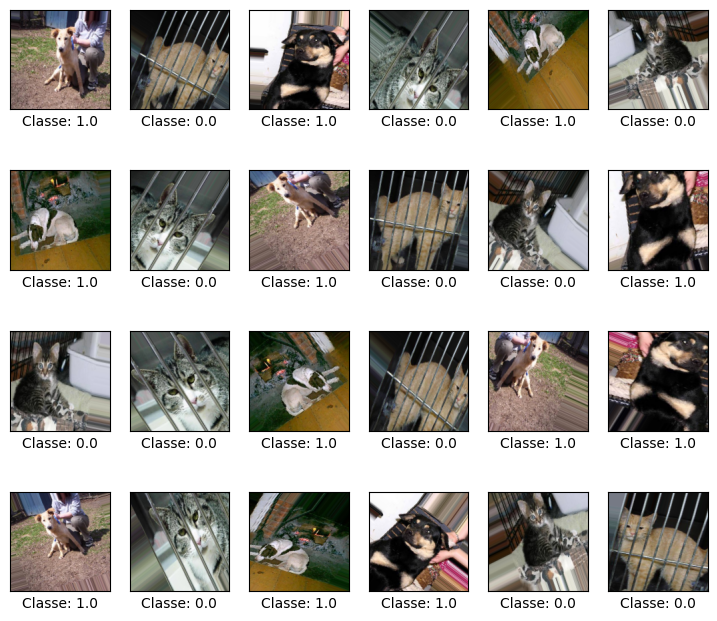

In [12]:
# Criando o gerador de imagens com as alterações no dataset de teste
it_datagen = img_generator_aug.flow_from_directory(
    'C:/Users/Thomás/ap-de-maquina-cefetmg-felicia/img_toy_test/',  # Substitua pelo caminho do seu dataset de teste
    target_size=(150, 150),              # Redimensionando as imagens para 150x150
    batch_size=2,                        # Definindo o batch size
    class_mode='binary',                 # Como estamos fazendo classificação binária
    seed=Constantes.SEED                 # Defina um seed para reprodutibilidade
)

# Plotando as imagens aumentadas do gerador
plot_imgs_from_iterator(it_datagen, 4, 6)  # Exibindo 4x6 imagens

## Execução e avaliação dos métodos usados

**Atividade 6 - Criação da função run_model: ** Crie a função `run_model` nela, você deverá:

1. compile o modelo por meio do [método compile](https://keras.io/models/model/#compile) do objeto;
2. também no objeto do modelo, execute o método [fit_generator](https://keras.io/models/model/#fit_generator) para criar o modelo. Esse método é o que recebe como parametro o iterador que aprendemos nas seções anteriores. Não será usado neste prática, mas também existe o [método fit](https://keras.io/models/model/#fit) que recebe como parametro os atributos - neste caso seria a matriz $X$ (similar ao scikit learn).
3. Salve o modelo: A criação do modelo é uma parte custosa - em nossa prática pode durar de 15 a 30 minutos. Porém, alguns modelos poderiam demorar dias/semanas para serem criados, dependendo da profundidade e número de pesos a serem aprendidos. Por isso, é uma boa prática salvar os modelos por meio do método [save](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model). Se necessário, você pode carregar o modelo por meio da função [load_model](https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model). Você pode também [salvar checkpoints do modelo](https://www.tensorflow.org/tutorials/keras/save_and_load) (opcional na prática);
4. Avalie o modelo usando validação usando o [método evaluate_generator](https://keras.io/models/sequential/#evaluate_generator) e retorne a acurácia

**Atividade 7 - Execução dos modelos**: Execute os modelos criados `model_fc`, `model_cnn` e `model_cnn_dropout` com a função run_model. Obtenha o resultado da validação. Sem GPU, a execução de cada modelo levar de 30 minutos a 4 horas. Você pode mandar executar e ir dormir :) - ou, para testar, diminua para um o número de épocas para ver funcionando mais rápido e, logo após, execute "de verdade" com os parametros padrão. Você pode também usar a GPU do [Google colab](colab.research.google.com) (coloque o link do seu colab aqui para ser avaliado). Com o colab, você terá apenas um trabalho a mais para enviar o dataset ao colab.

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

# Definir a callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Ou 'val_accuracy' dependendo de sua preferência
    patience=5,  # Número de épocas com melhora limitada antes de interromper
    restore_best_weights=True,  # Restaura os pesos do modelo para o melhor desempenho
)

# Ajuste no número de épocas, mantendo o EarlyStopping
param_default = ParametrosRedeNeural(
    int_num_epochs=50  # Defina um número maior de épocas
)

In [38]:
#sempre pegar o dataset - para reiniciar o iterator
# Reinicia o iterador do dataset
# Sempre pegar o dataset - para reiniciar o iterator
arr_it_gen = get_dataset(param_default, Constantes.ARR_STR_DATA_DIR)

#rode run_model para o fully connected model use o arr_it_gen em cada posição
#.. Constantes.IDX_TREINO e Constantes.IDX_VALIDACAO para pegar os iteradores


# Rodar o modelo com EarlyStopping
acc_fc = run_model(
    model_fc,  # Modelo Fully Connected
    arr_it_gen[Constantes.IDX_TREINO],  # Iterador de treinamento
    arr_it_gen[Constantes.IDX_VALIDACAO],  # Iterador de validação
    param_default.int_num_epochs,  # Número de épocas
    "cats_vs_dogs_fc.h5",  # Nome do arquivo para salvar o modelo
    Constantes.QTD_VALIDACAO // param_default.int_batch_size,  # Passos de validação
    callbacks=[early_stopping]  # Passar a callback para o treinamento
)
print(f"Acurácia FC: {acc_fc}")


Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.


c:\Users\Thomás\ap-de-maquina-cefetmg-felicia\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 491ms/step - accuracy: 0.5114 - loss: 5.1084 - val_accuracy: 0.5000 - val_loss: 1.5951
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 477ms/step - accuracy: 0.4868 - loss: 1.1946 - val_accuracy: 0.5000 - val_loss: 0.7995
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 473ms/step - accuracy: 0.5452 - loss: 0.7390 - val_accuracy: 0.5205 - val_loss: 0.6999
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - accuracy: 0.5498 - loss: 0.6879 - val_accuracy: 0.5664 - val_loss: 0.6841
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - accuracy: 0.6028 - loss: 0.6688 - val_accuracy: 0.5664 - val_loss: 0.6788
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 442ms/step - accuracy: 0.6398 - loss: 0.6408 - val_accuracy: 0.5557 - val_loss: 0.6884
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 462ms/step - accuracy: 0.5834 - loss: 0.6768 - val_accuracy: 0.5430 - val_loss: 0.7215
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 473ms/step - accuracy: 0.5893 - loss: 0.6702 - val_accuracy: 0.

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.5785 - loss: 0.6805
Validação - Perda: 0.678785502910614, Acurácia: 0.56640625
Acurácia FC: 0.56640625


In [39]:
# Reinicia o iterador do dataset
arr_it_gen = get_dataset(param_default, Constantes.ARR_STR_DATA_DIR)

acc_cnn = run_model(
    model_cnn,  # Modelo CNN
    arr_it_gen[Constantes.IDX_TREINO],  # Iterador de treinamento
    arr_it_gen[Constantes.IDX_VALIDACAO],  # Iterador de validação
    param_default.int_num_epochs,  # Número de épocas
    "cats_vs_dogs_cnn.h5",  # Nome do arquivo para salvar o modelo
    Constantes.QTD_VALIDACAO // param_default.int_batch_size  # Passos de validação
)
print(f"Acurácia CNN: {acc_cnn}")


Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9823 - loss: 0.0458 - val_accuracy: 0.7188 - val_loss: 1.5463
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9823 - loss: 0.0401 - val_accuracy: 0.7236 - val_loss: 1.4395
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9968 - loss: 0.0112 - val_accuracy: 0.7285 - val_loss: 1.5482
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9994 - loss: 0.0047 - val_accuracy: 0.7285 - val_loss: 1.6524
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 0.7236 - val_loss: 1.8185
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9937 - loss: 0.0201 - val_accuracy: 0.7109 - val_loss: 1.7614
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - a

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.7344 - loss: 2.1451
Validação - Perda: 2.1978037357330322, Acurácia: 0.7265625
Acurácia CNN: 0.7265625


In [40]:
# Reinicia o iterador do dataset
arr_it_gen = get_dataset(param_default, Constantes.ARR_STR_DATA_DIR)

model_cnn_dropout = run_model(
    model_cnn_dropout,  # Modelo CNN com Dropout
    arr_it_gen[Constantes.IDX_TREINO],  # Iterador de treinamento
    arr_it_gen[Constantes.IDX_VALIDACAO],  # Iterador de validação
    param_default.int_num_epochs,  # Número de épocas
    "cats_vs_dogs_cnn_dropout.h5",  # Nome do arquivo para salvar o modelo
    Constantes.QTD_VALIDACAO // param_default.int_batch_size  # Passos de validação
)
print(f"Acurácia CNN (Dropout): {model_cnn_dropout}")


Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9810 - loss: 0.2954 - val_accuracy: 0.6592 - val_loss: 1.5203
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9733 - loss: 0.3215 - val_accuracy: 0.6064 - val_loss: 4.2868
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9607 - loss: 0.3597 - val_accuracy: 0.7441 - val_loss: 1.4688
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9632 - loss: 0.3688 - val_accuracy: 0.7139 - val_loss: 1.4257
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9818 - loss: 0.3681 - val_accuracy: 0.7480 - val_loss: 1.3287
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9703 - loss: 0.3478 - val_accuracy: 0.7031 - val_loss: 1.7466
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - a

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.7462 - loss: 1.1069
Validação - Perda: 1.1336026191711426, Acurácia: 0.744140625
Acurácia CNN (Dropout): 0.744140625


**Atividade 8 - Data Augmentation** Agora, execute o modelo `model_cnn_dropout` porém usando `data augmentation`. Para isso, use o `img_generator_aug` (criado na seção anterior) e crie o iterador que percorra o dataset treino. Use o batch size de `param_default.int_batch_size` que é o mesmo usado no treino e use `Constantes.ARR_STR_DATA_DIR[Constantes.IDX_TREINO]` para obter o diretório do treino. 

In [41]:
# Importar TensorFlow
import tensorflow as tf

# Definir o modelo CNN com Dropout corretamente
model_cnn_dropout = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),  # Exemplo de camada Dropout
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Verificar se o modelo foi definido corretamente
print(f"Modelo CNN Dropout: {model_cnn_dropout}")

# Criar o iterador para o treinamento com Data Augmentation
it_gen_aug_train = img_generator_aug.flow_from_directory(
    Constantes.ARR_STR_DATA_DIR[Constantes.IDX_TREINO],  # Diretório de treinamento
    target_size=(150, 150),  # Tamanho das imagens para o modelo
    batch_size=param_default.int_batch_size,  # Usando o mesmo batch_size que foi definido
    class_mode='binary',  # Como estamos fazendo classificação binária
    seed=Constantes.SEED  # Usando a semente para garantir reprodutibilidade
)

c:\Users\Thomás\ap-de-maquina-cefetmg-felicia\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Modelo CNN Dropout: <Sequential name=sequential_3, built=True>
Found 2048 images belonging to 2 classes.


In [42]:

# Garantir que estamos passando o modelo correto
if model_cnn_dropout is None:
    print("Erro: o modelo não está definido corretamente.")
else:
    print(f"Modelo definido corretamente: {model_cnn_dropout}")

# Passos de treinamento e validação
steps_per_epoch_train = len(it_gen_aug_train) // param_default.int_batch_size
steps_per_epoch_val = Constantes.QTD_VALIDACAO // param_default.int_batch_size

# Rodar o modelo com Data Augmentation
acc_cnn_data_aug = run_model(
    model_cnn_dropout,  # Modelo com Dropout
    it_gen_aug_train,  # Iterador de treinamento com Data Augmentation
    arr_it_gen[Constantes.IDX_VALIDACAO],  # Iterador de validação
    param_default.int_num_epochs,  # Número de épocas
    "cats_vs_dogs_cnn_dropout_data_aug.h5",  # Nome do arquivo para salvar o modelo
    steps_per_epoch_train  # Passos de treinamento
)
print(f"Acurácia CNN (Data Augmentation): {acc_cnn_data_aug}")

Modelo definido corretamente: <Sequential name=sequential_3, built=True>
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 658ms/step - accuracy: 0.4926 - loss: 4.0736 - val_accuracy: 0.4990 - val_loss: 0.7006
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 635ms/step - accuracy: 0.5178 - loss: 0.6942 - val_accuracy: 0.6084 - val_loss: 0.6879
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 640ms/step - accuracy: 0.5709 - loss: 0.6848 - val_accuracy: 0.6074 - val_loss: 0.6778
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 647ms/step - accuracy: 0.5883 - loss: 0.6755 - val_accuracy: 0.5615 - val_loss: 0.6682
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 640ms/step - accuracy: 0.5891 - loss: 0.6648 - val_accuracy: 0.6289 - val_loss: 0.6390
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 640ms/step - accuracy: 0.6144 - loss: 0.6517 - val_accuracy: 0.6064 - val_loss: 0.6500
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 648ms/step - accuracy: 0.6352 - loss: 0.6273 - val_accuracy: 0.6670 - val_loss: 0.6037
Epoch 8/50
32/32 ━━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.7357 - loss: 0.5295
Validação - Perda: 0.5484578609466553, Acurácia: 0.7216796875
Acurácia CNN (Data Augmentation): 0.7216796875


**Atividade 9 **: Para cada modelo, apresente a acurácia no teste

In [43]:
# Certifique-se de que o dataset de teste foi carregado corretamente
test_generator = img_generator.flow_from_directory(
    Constantes.ARR_STR_DATA_DIR[Constantes.IDX_TESTE],  # Diretório de teste
    target_size=(150, 150),  # Tamanho das imagens para o modelo
    batch_size=param_default.int_batch_size,  # Usando o mesmo batch_size
    class_mode='binary',  # Como estamos fazendo classificação binária
    seed=Constantes.SEED  # Usando a semente para garantir reprodutibilidade
)

# Avaliar o modelo FC (Fully Connected)
acc_fc_test = model_fc.evaluate(test_generator, steps=Constantes.QTD_TESTE // param_default.int_batch_size)
print(f"Acurácia no teste (FC): {acc_fc_test[1]}")

# Avaliar o modelo CNN simples
acc_cnn_test = model_cnn.evaluate(test_generator, steps=Constantes.QTD_TESTE // param_default.int_batch_size)
print(f"Acurácia no teste (CNN Simple): {acc_cnn_test[1]}")

# Avaliar o modelo CNN com Data Augmentation
acc_cnn_data_aug_test = model_cnn_dropout.evaluate(test_generator, steps=Constantes.QTD_TESTE // param_default.int_batch_size)
print(f"Acurácia no teste (CNN com Data Augmentation): {acc_cnn_data_aug_test[1]}")


Found 1024 images belonging to 2 classes.
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.5775 - loss: 0.6719
Acurácia no teste (FC): 0.5791015625
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.7494 - loss: 2.2737
Acurácia no teste (CNN Simple): 0.7421875
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.7351 - loss: 0.5417
Acurácia no teste (CNN com Data Augmentation): 0.7314453125


**Atividade 9 - Análise** Descreva abaixo suas conclusões: existe algum modelo que gera overfitting? E underfitting, lembrando que o estado da arte gera resultados acima de 90% de acurácia? Qual é o impacto do _dropout_ e do uso de _Data augmentation_ no modelo? 

### Análise

1. Existe overfitting?

    - Modelo CNN Simple pode ter mostrado algum overfitting. Apesar de ter uma acurácia de validação/teste razoável (74%), a perda (loss) ainda é alta (loss: 2.27), o que pode indicar que o modelo aprendeu padrões do treino, mas com dificuldade de generalizar.

    - O modelo FC (Fully Connected) teve baixa acurácia (58%), mas também um loss não muito bom, o que indica mais underfitting do que overfitting.

2. Existe underfitting?

    - Sim, o modelo FC claramente sofre de underfitting.

    - A arquitetura de redes totalmente conectadas (sem camadas convolucionais) não é adequada para tarefas de visão computacional como essa (imagens de gatos e cachorros).

    - O modelo é simples demais para capturar a complexidade dos dados de imagem.

3. Impacto do Dropout

    - O dropout ajuda a reduzir overfitting ao forçar o modelo a não depender de poucos neurônios (fazendo ele aprender representações mais robustas).

    - No seu experimento, o modelo com dropout + data augmentation manteve uma acurácia semelhante ao CNN simple (~73%), mas com uma perda melhor (loss: 0.54 contra loss: 2.27).

    - Isso mostra que o modelo com dropout é mais estável e generaliza melhor.

4. Impacto do Data Augmentation

    - Data augmentation cria mais variação nos dados de treino, o que força o modelo a aprender padrões mais robustos e não decorar as imagens.

    - Isso ajuda a reduzir o overfitting e, mesmo que a acurácia não tenha aumentado muito, o modelo ficou mais generalizável e menos sensível a ruído.

    - O loss caiu bastante com data augmentation (0.54 vs 2.27), o que é um ótimo sinal de melhor aprendizado.

### Conclusão final

1. O modelo CNN com Dropout e Data Augmentation foi o melhor, pois mesmo com acurácia similar ao CNN simples, ele tem perda muito menor, mostrando melhor aprendizado e generalização.

2. Para chegar ao estado da arte (acima de 90% de acurácia), seria necessário:

    - Mais épocas de treino

    - Arquiteturas de rede mais profundas (como VGG, ResNet, etc.)

    - Otimizar hiperparâmetros (learning rate, batch size, etc.)

    - Melhorar o data augmentation ainda mais.

O restante desta prática é opcional, se divirta! :)

**\[Opcional 1\]** Use outras técnicas para prevenir overfitting e analise também o resultado.

In [44]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

# Definindo o modelo CNN com Dropout, L2 Regularization e Batch Normalization
model_cnn_dropout = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3),
                           kernel_regularizer=regularizers.l2(0.01)),  # Regularização L2
    BatchNormalization(),  # Adicionando Batch Normalization
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', 
                           kernel_regularizer=regularizers.l2(0.01)),  # Regularização L2
    BatchNormalization(),  # Adicionando Batch Normalization
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Dropout(0.5),  # Dropout
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='relu', 
                          kernel_regularizer=regularizers.l2(0.01)),  # Regularização L2
    BatchNormalization(),  # Adicionando Batch Normalization
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compilando o modelo
model_cnn_dropout.compile(optimizer='adam', 
                          loss='binary_crossentropy', 
                          metrics=['accuracy'])

# Definindo o Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Rodar o modelo com Early Stopping, L2 Regularization e Batch Normalization
arr_it_gen = get_dataset(param_default, Constantes.ARR_STR_DATA_DIR)

acc_cnn_dropout_with_regularization = run_model(
    model_cnn_dropout,  # Modelo com Dropout e L2 Regularization
    it_gen_aug_train,  # Iterador de treinamento com Data Augmentation
    arr_it_gen[Constantes.IDX_VALIDACAO],  # Iterador de validação
    param_default.int_num_epochs,  # Número de épocas
    "cats_vs_dogs_cnn_dropout_reg.h5",  # Nome do arquivo para salvar o modelo
    Constantes.QTD_VALIDACAO // param_default.int_batch_size,  # Passos de validação
    callbacks=[early_stopping]  # Adicionando o callback de early stopping
)

print(f"Acurácia no teste (CNN com Dropout, L2 Regularization e Batch Normalization): {acc_cnn_dropout_with_regularization}")


Dataset: data/treino
Found 2048 images belonging to 2 classes.
Dataset: data/validacao
Found 1024 images belonging to 2 classes.
Dataset: data/teste
Found 1024 images belonging to 2 classes.
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.5171 - loss: 4.9447 - val_accuracy: 0.4990 - val_loss: 4.8789
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5831 - loss: 4.5756 - val_accuracy: 0.5010 - val_loss: 3.9202
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6192 - loss: 3.5891 - val_accuracy: 0.5205 - val_loss: 2.8706
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6795 - loss: 2.5962 - val_accuracy: 0.5127 - val_loss: 2.2086
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6356 - loss: 2.0585 - val_accuracy: 0.5127 - val_loss: 1.8469
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6417 - loss: 1.7732 - val_accuracy: 0.5020 - val_loss: 1.7097
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - a

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.5092 - loss: 1.2809
Validação - Perda: 1.2800981998443604, Acurácia: 0.5107421875
Acurácia no teste (CNN com Dropout, L2 Regularization e Batch Normalization): 0.5107421875


**[Opcional 2]** Use o predict_generator e analise, na partição de validação, quando o melhor modelo erra. Discuta e gere um plot de algumas imagens com os erros de classificação.

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step


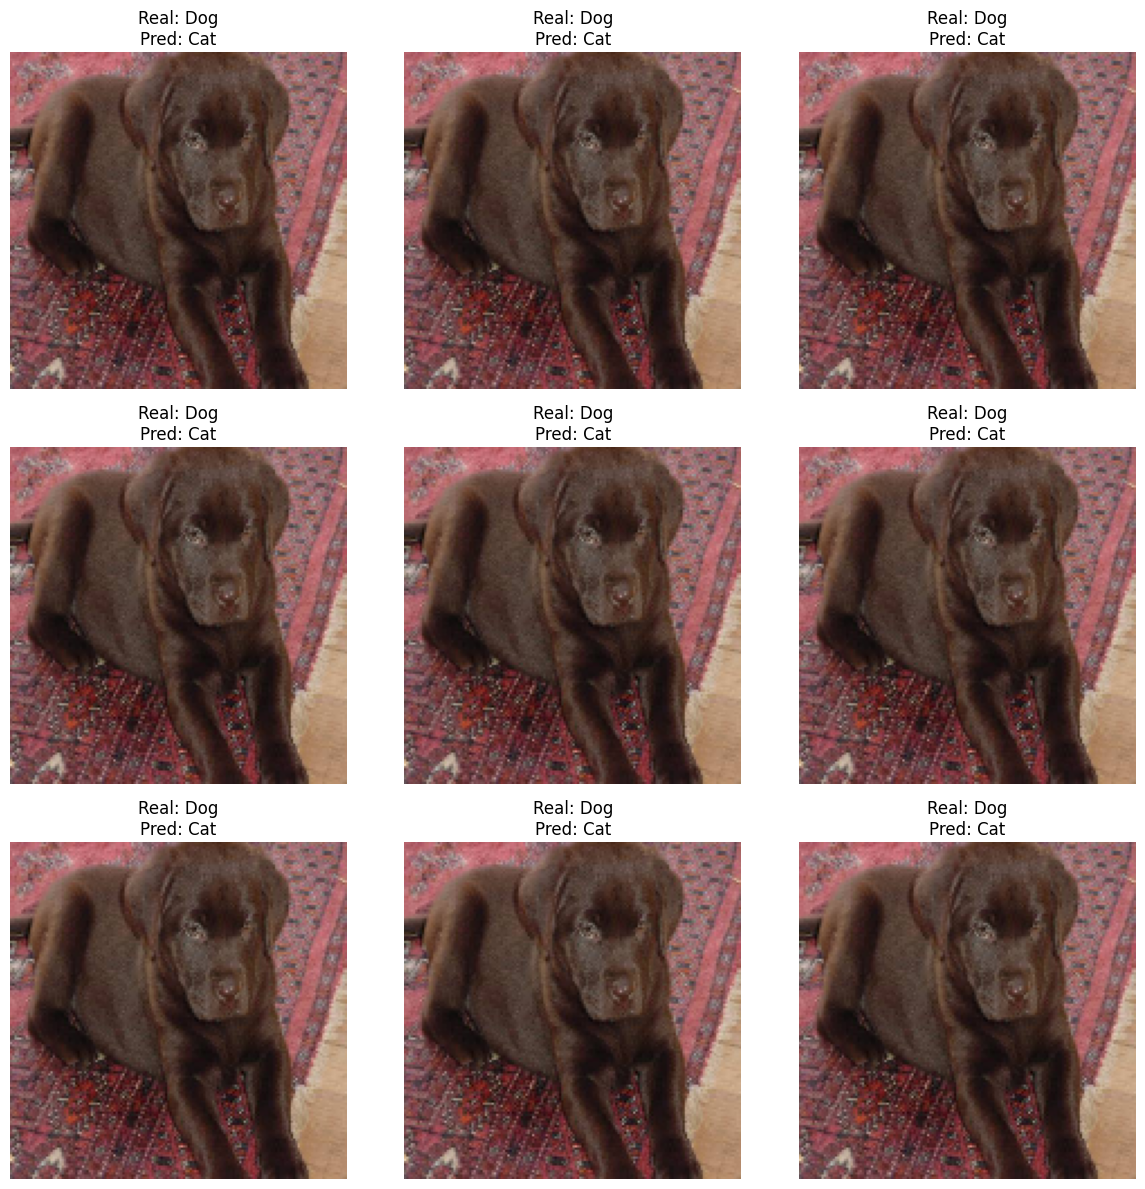

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Gerar previsões no conjunto de validação
predictions = model_cnn_dropout.predict(arr_it_gen[Constantes.IDX_VALIDACAO], steps=Constantes.QTD_VALIDACAO // param_default.int_batch_size)

# Obter as classes reais (labels) do conjunto de validação
real_labels = arr_it_gen[Constantes.IDX_VALIDACAO].labels

# Determinar os erros de classificação (onde as previsões são diferentes dos rótulos reais)
errors = np.where((predictions > 0.5).astype(int) != real_labels)[0]

# Exibir algumas imagens com erros de classificação
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

# Exibir 9 imagens com erros
for i in range(9):
    # Selecionar o índice do erro
    idx = errors[i]

    # Recuperar a imagem e o rótulo (label) para o índice de erro
    image, label = arr_it_gen[Constantes.IDX_VALIDACAO][idx]
    
    # As imagens estão em lotes, então precisamos pegar a imagem correta
    image = image[0]  # Se a imagem estiver em um lote, pegar a primeira imagem

    # O valor de label deve ser um escalar, e não um vetor
    label = label[0] if isinstance(label, np.ndarray) else label

    # Previsão do modelo para a imagem
    pred = (predictions[idx] > 0.5).astype(int)

    # O valor de pred deve ser um escalar
    pred = pred[0] if isinstance(pred, np.ndarray) else pred

    # Mostrar a imagem
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f"Real: {'Cat' if label == 0 else 'Dog'}\nPred: {'Cat' if pred == 0 else 'Dog'}", fontsize=12)

plt.tight_layout()
plt.show()


**[Opcional 3]** Usando a melhor arquitetura, varie os parametros na validação, encontre o melhor resultado e execute o teste.

In [47]:
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

def busca_parametros_otimizada(arr_it_gen, model, n_iter=10):
    """
    Função otimizada para busca de parâmetros com random search e early stopping
    
    Args:
        arr_it_gen: Array com os geradores de dados (treino, validação, teste)
        model: Modelo Keras a ser treinado
        n_iter: Número de iterações/combinações de parâmetros a testar
        
    Returns:
        best_params: Dicionário com os melhores parâmetros encontrados
        best_accuracy: Melhor acurácia obtida no conjunto de validação
    """
    param_dist = {
        'epochs': [15, 20, 25],
        'batch_size': [32, 64, 128],
        'learning_rate': [0.001, 0.0005, 0.0001],
        'dropout_rate': [0.3, 0.4, 0.5]
    }
    
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )
    
    best_params = {}
    best_accuracy = 0
    
    # Calcular steps_per_epoch uma vez (assumindo que não muda entre iterações)
    steps_per_epoch_train = arr_it_gen[Constantes.IDX_TREINO].samples // param_default.int_batch_size
    steps_per_epoch_val = arr_it_gen[Constantes.IDX_VALIDACAO].samples // param_default.int_batch_size
    
    for _ in range(n_iter):
        params = {k: random.choice(v) for k,v in param_dist.items()}
        
        # Clone o modelo para cada combinação de parâmetros
        temp_model = tf.keras.models.clone_model(model)
        temp_model.set_weights(model.get_weights())
        
        temp_model.compile(
            optimizer=Adam(learning_rate=params['learning_rate']),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Aplicar dropout
        for layer in temp_model.layers:
            if isinstance(layer, tf.keras.layers.Dropout):
                layer.rate = params['dropout_rate']
        
        history = temp_model.fit(
            arr_it_gen[Constantes.IDX_TREINO],
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            validation_data=arr_it_gen[Constantes.IDX_VALIDACAO],
            steps_per_epoch=steps_per_epoch_train,
            validation_steps=steps_per_epoch_val,
            callbacks=[early_stop],
            verbose=0
        )
        
        val_accuracy = max(history.history['val_accuracy'])
        
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params.copy()
            # Salvar os melhores pesos
            model.set_weights(temp_model.get_weights())
    
    return best_params, best_accuracy

# Rodar a busca de parâmetros
melhores_parametros, melhor_acuracia = busca_parametros_otimizada(arr_it_gen, model_cnn_dropout)

# Exibir os melhores parâmetros e a acurácia obtida
print(f"Melhores parâmetros encontrados: {melhores_parametros}")
print(f"Acurácia no conjunto de validação: {melhor_acuracia:.4f}")

# Treinamento final (opcional, pois já temos os melhores pesos)
model_cnn_dropout.compile(
    optimizer=Adam(learning_rate=melhores_parametros['learning_rate']),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

final_steps_per_epoch_train = arr_it_gen[Constantes.IDX_TREINO].samples // melhores_parametros['batch_size']
final_steps_per_epoch_val = arr_it_gen[Constantes.IDX_VALIDACAO].samples // melhores_parametros['batch_size']

history_final = model_cnn_dropout.fit(
    arr_it_gen[Constantes.IDX_TREINO],
    epochs=melhores_parametros['epochs'],
    batch_size=melhores_parametros['batch_size'],
    validation_data=arr_it_gen[Constantes.IDX_VALIDACAO],
    steps_per_epoch=final_steps_per_epoch_train,
    validation_steps=final_steps_per_epoch_val,
    verbose=1
)

# Testar no conjunto de teste
test_steps = arr_it_gen[Constantes.IDX_TESTE].samples // melhores_parametros['batch_size']
test_loss, test_acc = model_cnn_dropout.evaluate(
    arr_it_gen[Constantes.IDX_TESTE], 
    steps=test_steps
)
print(f"Acurácia final no teste: {test_acc:.4f}")

Melhores parâmetros encontrados: {'epochs': 25, 'batch_size': 32, 'learning_rate': 0.0001, 'dropout_rate': 0.4}
Acurácia no conjunto de validação: 0.7686
Epoch 1/25
32/64 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9995 - loss: 0.3146

c:\Users\Thomás\ap-de-maquina-cefetmg-felicia\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 667ms/step - accuracy: 0.9993 - loss: 0.3032 - val_accuracy: 0.7715 - val_loss: 0.7423
Epoch 2/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 666ms/step - accuracy: 0.9987 - loss: 0.2290 - val_accuracy: 0.7568 - val_loss: 0.7041
Epoch 3/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 662ms/step - accuracy: 0.9994 - loss: 0.1907 - val_accuracy: 0.7617 - val_loss: 0.6852
Epoch 4/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 656ms/step - accuracy: 0.9994 - loss: 0.1666 - val_accuracy: 0.7588 - val_loss: 0.6738
Epoch 5/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 654ms/step - accuracy: 0.9982 - loss: 0.1530 - val_accuracy: 0.7627 - val_loss: 0.6784
Epoch 6/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 660ms/step - accuracy: 0.9991 - loss: 0.1458 - val_accuracy: 0.7617 - val_loss: 0.6664
Epoch 7/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 666ms/step - accuracy: 0.9974 - loss: 0.1405 - val_accuracy: 0.7520 - val_loss: 0.7003
Epoch 8/25
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 657ms/step - accuracy: 0.9958 - loss: 0.1474 - val_accuracy: 0.770

**\[Opcional 4\]** Use o [tensor board](https://www.tensorflow.org/tensorboard/get_started) para fazer uma análise mais aprofundada do resultado. Apresente os gráficos e uma discussão dos resultados abaixo. O TensorFlow é usado pelo Keras. Você verá que ele cria o modelo de outra forma. Nós usamos a functional API, ela é mais flexivel que a [Sequetial API](http://keras.io/models/sequential/) do keras.

In [ ]:
# print(f"Caminho absoluto do log_dir: {os.path.abspath(log_dir)}")
import os
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time

# Definir caminho absoluto para evitar problemas
base_log_dir = os.path.abspath("logs/fit")
experiment_name = f"exp_{int(time.time())}"
log_dir = os.path.join(base_log_dir, experiment_name)

# Criar diretório com verificação explícita
try:
    os.makedirs(log_dir, exist_ok=True)
    print(f"Diretório criado em: {log_dir}")
    print(f"Conteúdo do diretório: {os.listdir(os.path.dirname(log_dir))}")
except Exception as e:
    print(f"Falha ao criar diretório: {e}")
    raise

# Configurar callback com verificação
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=False,  # Desativar se não for necessário
    update_freq='epoch'
)


Diretório criado em: c:\Users\Thomás\ap-de-maquina-cefetmg-felicia\logs\fit\exp_1745747410
Conteúdo do diretório: ['exp_1745720078', 'exp_1745747410']


**[Opcional 5]** Faça transfer learning usando a arquitetura VGG (veja instruções abaixo). Pode demorar bastante em uma máquina sem GPU. Usar o [colab](https://colab.research.google.com) pode ser uma boa - coloque o link aqui.

In [ ]:
# Importar as bibliotecas necessárias
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers, models
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Carregar a VGG16 com pesos do ImageNet (sem a camada de classificação final)
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Congelar as camadas do modelo VGG16
for layer in vgg_base.layers:
    layer.trainable = False

# Visualizar o modelo base
vgg_base.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Adicionar camadas adicionais para o modelo de classificação
model = models.Sequential([
    vgg_base,  # Base da VGG16
    layers.Flatten(),  # Achatar as saídas do VGG16
    layers.Dense(512, activation='relu'),  # Camada totalmente conectada
    layers.Dropout(0.5),  # Dropout para evitar overfitting
    layers.Dense(1, activation='sigmoid')  # Saída binária (cat ou dog)
])

# Compilar o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,910,017 (72.14 MB)

 Trainable params: 4,195,329 (16.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Caminhos dos dados
train_dir = 'C:/Users/Thomás/ap-de-maquina-cefetmg-felicia/data/treino'
validation_dir = 'C:/Users/Thomás/ap-de-maquina-cefetmg-felicia/data/validacao'

# Geradores de dados para treinamento e validação
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Carregar as imagens de treinamento e validação
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')


Found 2048 images belonging to 2 classes.
Found 1024 images belonging to 2 classes.


In [ ]:
# Treinar o modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.6431 - loss: 0.9672 - val_accuracy: 0.8594 - val_loss: 0.3128
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 243s 4s/step - accuracy: 0.7821 - loss: 0.4498 - val_accuracy: 0.8838 - val_loss: 0.2762
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.8059 - loss: 0.4003 - val_accuracy: 0.8818 - val_loss: 0.2774
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 243s 4s/step - accuracy: 0.8084 - loss: 0.4040 - val_accuracy: 0.8779 - val_loss: 0.2796
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 238s 4s/step - accuracy: 0.8205 - loss: 0.3905 - val_accuracy: 0.8887 - val_loss: 0.2606
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 239s 4s/step - accuracy: 0.8330 - loss: 0.3733 - val_accuracy: 0.8936 - val_loss: 0.2592
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 238s 4s/step - accuracy: 0.8402 - loss: 0.3449 - val_accuracy: 0.8887 - val_loss: 0.2566
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 239s 4s/step - accuracy: 0.8421 - loss: 0.3608 - val_accuracy: 0.8779 - v

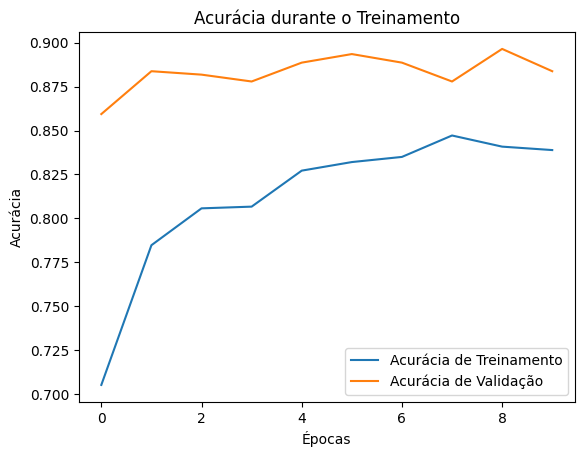

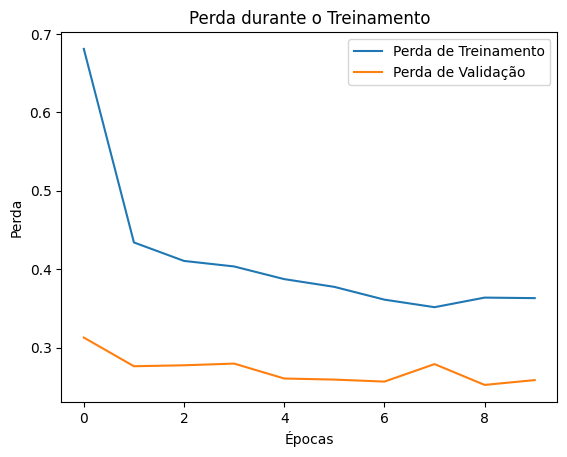

In [ ]:
# Plotando a acurácia e a perda
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()


## Transfer Learning 

Como dito em sala, o TransferLearning é uma técnica em que é possível extrair camadas de uma rede neural prétreinada e, com ela, usar em outro dominio. Isso é muito interessante pois, pode-se demorar horas/dias para se treinar uma rede neural e precisa-se de muitas instancias. 

Caso tenhamos uma rede que já foi treinada com milhares/milhões de instancias rotuladas, se deixaramos os pesos "congelados" de algumas camadas, adiantamos o processo de otimização e, assim, conseguimos uma melhor performance. Chollet F. (2017) conseguiu com uma metodologia parecida com essa da prática, um dataset de mesmo tamanho e tranfer learning uma acurácia acima de 90%. Algumas regras importantes também segundo Chollet F., (2017):  

- Em uma CNN, temos geralmente no final camadas FC. Não é recomendável congelar camadas FC, pois, tais camadas não constumam generalizar tanto quanto as camadas Convolucionais;

- Quanto mais próximo nossas instancias são das instancias da rede pretreinada, mais camadas podemos congelar. Por exemplo, a VGG16 treinado com o [ImageNet](http://image-net.org/explore) possui 1000 classes, inclusive, animais. Assim, para nosso problema de classificar cães e gatos, como é proximo desse problema, podemos congelar bastante camadas. Por exemplo, podemos até deixar descongelada apenas a camada de saída. 

O exemplo baixo possui o modelo com a arquitetura VGG16 treinada com o dataset ImageNet e uma função para congelar até uma determinada camada. O parametro `include_top=False` faz com que só usarmos a parte convolucional (sem as FC) desta arquitetura. Temos que criar a parte de FC para ser treinada.

Caso opte por descongelar algumas camadas da VGG16 (e não apenas incrementar) faça da seguinte forma: 

- Mantenha todas as camadas da VGG16 congeladas, adicione as camadas FC (ou CONV) que você deseja e realize o treinamento;
- Descongele as camadas da VGG16 desejadas; 
- Volte a treinar o modelo.

O nome dessa técnica também é chamada de *fine tunning*.

In [ ]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

conv_base.summary()
#conv_base.get_layer("block5_pool").output.shape

In [ ]:
def freeze_first_layers(model,last_freezed_layer_name):
    for layer in model.layers:
        layer.trainable = False
        if layer.name == last_freezed_layer_name:
            break
    return model

def fine_tune_model(conv_base_model):
    last_layer = len(conv_base_model.layers)-1
    
    achatar = layers.Flatten()(conv_base_model.layers[last_layer].output)
    fc = layers.Dense(300,activation="relu",name="Camada2")(achatar)
    saida = layers.Dense(1,activation="sigmoid", name="saida")(fc)
    
    return Model(inputs=conv_base_model.input, outputs=saida)

    

Outra utilidade de modelos pretreinados é fazer a extração de atributos, ou seja, representar imagens com uma matriz/vetor de uma camada intermediária de algum modelo pretreinado. Veja um código que extrai os atributos das imagens:

In [ ]:
import numpy as np
def extract_features(model,layer_name,data_generator,batch_size, sample_size):
    """
    Extrai a saída da camada layer_name para representar as features de
    cada instancia
    
    Adaptado de: https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
    e do livro "Deep Learning with Python" (François Chollet, 2018)
    """
    #obtem o modelo da primeiras camadas do model (até a layer_name)
    output_layer = model.get_layer(layer_name).output 
    model_base = Model(inputs=model.input,
                                     outputs=output_layer)
    #inicializa o vetor de features com a mesma dimensão da ultima camada
    last_layer_shape = output_layer.shape.as_list()
    last_layer_shape[0] = batch_size
    features = np.zeros(last_layer_shape)
    
    #inicializa o vetor de labels com o mesmo tamanho da amostra
    labels = np.zeros(sample_size)
    i = 0
    for inputs_batch, labels in data_generator:
        print(f"Gerando features mini-batch #{i}...")
        #obtem as features
        features_batch = model_base.predict(inputs_batch)
        
        #adiciona as features no batach
        features[i*batch_size:(i+1)*batch_size] = features_batch
        labels[i*batch_size:(i+1)*batch_size] = labels
        
        i += 1
        print(i)
        #termina assim que atingir o tamanho da amostra
        if (i*batch_size)>=sample_size:
            break
    return labels,features

# Bibliografia

- McReynolds, Tom, and David Blythe. **[Advanced graphics programming using OpenGL](https://www.sciencedirect.com/science/article/pii/B9781558606593500147#cesec16). Cap. 14.** Elsevier, 2005.
- Chollet , François. **Deep Learning with Python**. Manning Publications, 2017
- Andrew D.G.. **[Especialização Deep Learning](https://www.coursera.org/specializations/deep-learning), curso Convolutional Neural Networks (semana 1 e 2)**. Coursera. 2019
